In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- New Imports for Modeling ---

# 1. Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 2. The Model (Our "Hierarchical Model")
from sksurv.ensemble import RandomSurvivalForest

# 3. Evaluation Metric
# (We are removing the broken import from here)
from sksurv.metrics import concordance_index_censored

# Set display options and plot style
pd.set_option('display.max_columns', 100)
%matplotlib inline
sns.set_style("whitegrid")

print("Modeling libraries imported successfully.")

Modeling libraries imported successfully.


In [2]:
# Define the path to our clean data
data_path = '../data/cleaned_loan_data.parquet'

# Load the data
df = pd.read_parquet(data_path)

# Display to confirm it's all there
print(f"Data loaded successfully! Shape: {df.shape}")
print(df.head())
df.info()

Data loaded successfully! Shape: (1333668, 15)
   loan_amnt  term  int_rate grade sub_grade  emp_length home_ownership  \
0     3600.0    36     13.99     C        C4        10.0       MORTGAGE   
1    24700.0    36     11.99     C        C1        10.0       MORTGAGE   
2    20000.0    60     10.78     B        B4        10.0       MORTGAGE   
3    10400.0    60     22.45     F        F1         3.0       MORTGAGE   
4    11950.0    36     13.44     C        C3         4.0           RENT   

   annual_inc    issue_d loan_status             purpose    dti last_pymnt_d  \
0     55000.0 2015-12-01  Fully Paid  debt_consolidation   5.91   2019-01-01   
1     65000.0 2015-12-01  Fully Paid      small_business  16.06   2016-06-01   
2     63000.0 2015-12-01  Fully Paid    home_improvement  10.78   2017-06-01   
3    104433.0 2015-12-01  Fully Paid      major_purchase  25.37   2016-07-01   
4     34000.0 2015-12-01  Fully Paid  debt_consolidation  10.20   2017-05-01   

   event  duration_mo

In [3]:
# Define our feature lists
# We are dropping columns that we don't need for modeling
features_to_drop = [
    'sub_grade',      # 'grade' is a better, less noisy feature
    'issue_d',        # Date is no longer needed
    'loan_status',    # This was used to create 'event'
    'last_pymnt_d'    # Date is no longer needed
]

df_model = df.drop(columns=features_to_drop)

# Find our categorical columns
categorical_cols = df_model.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns to encode: {list(categorical_cols)}")

# Perform one-hot encoding
df_model_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

print(f"\nData shape *after* encoding: {df_model_encoded.shape}")
print(df_model_encoded.head())

Categorical columns to encode: ['grade', 'home_ownership', 'purpose']

Data shape *after* encoding: (1333668, 32)
   loan_amnt  term  int_rate  emp_length  annual_inc    dti  event  \
0     3600.0    36     13.99        10.0     55000.0   5.91      0   
1    24700.0    36     11.99        10.0     65000.0  16.06      0   
2    20000.0    60     10.78        10.0     63000.0  10.78      0   
3    10400.0    60     22.45         3.0    104433.0  25.37      0   
4    11950.0    36     13.44         4.0     34000.0  10.20      0   

   duration_months  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G  \
0             37.0    False     True    False    False    False    False   
1              6.0    False     True    False    False    False    False   
2             18.0     True    False    False    False    False    False   
3              7.0    False    False    False    False     True    False   
4             17.0    False     True    False    False    False    False   

   home_

In [ ]:
# 1. Separate features (X) from the target variables (event and duration)
X = df_model_encoded.drop(columns=['event', 'duration_months'])
y_temp = df_model_encoded[['event', 'duration_months']]

# 2. Create the structured NumPy array required by scikit-survival
# This array combines the event status (E) and time (T) into a single object.
y = np.array(
    list(zip(
        y_temp['event'].astype(bool), 
        y_temp['duration_months'].astype(float)
    )),
    dtype=[('event', '?'), ('time', '<f8')]
)

# 3. Display the separated arrays for inspection
print("Features (X):")
print(X.head())

print("\nTarget (y) - a structured array of (event, time):")
print(y[:5])

Features (X):
   loan_amnt  term  int_rate  emp_length  annual_inc    dti  grade_B  grade_C  \
0     3600.0    36     13.99        10.0     55000.0   5.91    False     True   
1    24700.0    36     11.99        10.0     65000.0  16.06    False     True   
2    20000.0    60     10.78        10.0     63000.0  10.78     True    False   
3    10400.0    60     22.45         3.0    104433.0  25.37    False    False   
4    11950.0    36     13.44         4.0     34000.0  10.20    False     True   

   grade_D  grade_E  grade_F  grade_G  home_ownership_MORTGAGE  \
0    False    False    False    False                     True   
1    False    False    False    False                     True   
2    False    False    False    False                     True   
3    False    False     True    False                     True   
4    False    False    False    False                    False   

   home_ownership_NONE  home_ownership_OTHER  home_ownership_OWN  \
0                False            

In [ ]:
from sklearn.model_selection import train_test_split

# We'll use 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set:     {X_test.shape[0]} samples")

Training set: 1066934 samples
Test set:     266734 samples


In [ ]:
print(f"Original training size: {X_train.shape[0]}")

# We will take a 30% random sample for training
sample_size = 0.30

# Use train_test_split to get a reproducible, stratified sample
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, 
    train_size=sample_size, 
    random_state=42, 
    stratify=[e for e, t in y_train] # This keeps the same default rate
)

print(f"New sample training size: {X_train_sample.shape[0]}")

Original training size: 1066934
New sample training size: 320080


In [ ]:
print(f"Building and training the final model on {X_train_sample.shape[0]} samples...")

from joblib import parallel_backend

# 1. Create the model instance (our smart parameters)
rsf = RandomSurvivalForest(
    n_estimators=100,      
    min_samples_leaf=1000, # Still smart and pruned
    n_jobs=-1,             # Use all 8 cores
    random_state=42,
    verbose=1              
)

# 2. Train the model
print("Training with 'loky' backend... This will now be very fast.")

with parallel_backend('loky'):
    rsf.fit(X_train_sample, y_train_sample)

print("Model training complete!")

Building and training the final model on 320080 samples...
Training with 'loky' backend... This will now be very fast.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.1min


Model training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 57.1min finished


In [ ]:
from sksurv.metrics import concordance_index_censored

# 1. Use the trained model to score the (full) test data
print("Evaluating the model on the full test set...")

c_index = rsf.score(X_test, y_test)

print(f"Model evaluation complete.")
print(f"Concordance Index (C-Index): {c_index:.4f}")
print("\n(Note: 0.5 is a random guess, 1.0 is perfect. A score > 0.65 is a great result for this complex data!)")

Evaluating the model on the full test set...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   33.5s finished


Model evaluation complete.
Concordance Index (C-Index): 0.6839

(Note: 0.5 is a random guess, 1.0 is perfect. A score > 0.65 is a great result for this complex data!)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

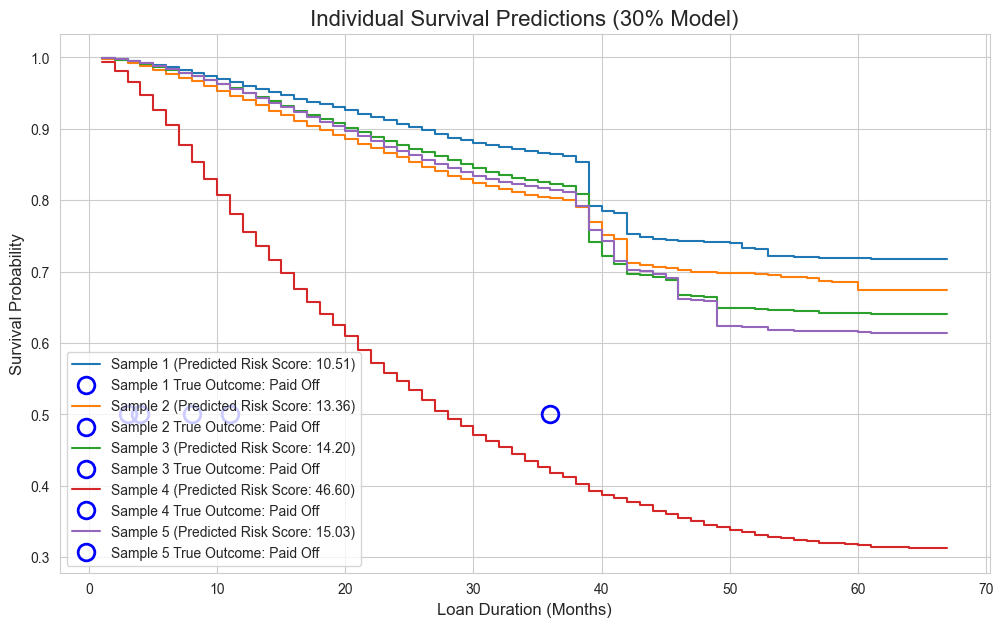

In [20]:
# 1. Get predictions for a few samples from the test set
X_test_samples = X_test.iloc[:5]
y_test_samples = y_test[:5]

# 2. Get the predicted survival curves from our model
pred_surv_curves = rsf.predict_survival_function(X_test_samples)

# 3. Plot the results
plt.figure(figsize=(12, 7))

for i, curve in enumerate(pred_surv_curves):
    true_event = y_test_samples[i][0]
    true_duration = y_test_samples[i][1]
    
    plt.step(
        curve.x, 
        curve.y, 
        where="post", 
        label=f"Sample {i+1} (Predicted Risk Score: {rsf.predict(X_test_samples)[i]:.2f})"
    )
    
    if true_event:
        plt.plot(
            true_duration, 0.5, 'rx', markersize=12, markeredgewidth=2,
            label=f"Sample {i+1} True Outcome: Defaulted"
        )
    else:
        plt.plot(
            true_duration, 0.5, 'bo', markersize=12, fillstyle='none', markeredgewidth=2,
            label=f"Sample {i+1} True Outcome: Paid Off"
        )

plt.title("Individual Survival Predictions (30% Model)", fontsize=16)
plt.xlabel("Loan Duration (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.legend()
plt.show()